In [7]:
import matplotlib.pyplot as plt
import pandas as pd

import os
import torch
import numpy as np
from tqdm import tqdm
from autoencoder import train_autoencoder
from mMDS_NN import train_mMDS
from wspd import *
from generate_points import generate_data
from my_utils import plot_box

is_cuda = torch.cuda.is_available()
if is_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

######### SET PARAMETERS
out_dim = 2
S=2
# set what activation function to use
ac_fn = nn.Tanh()
#ac_fn = nn.ReLU()
DIMENSIONS = [2, 3, 4, 5, 6, 8, 16, 32]
refine = True
#########

seed = 69
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

datasets = []
for input_dim in DIMENSIONS:
    datasets.append(pd.DataFrame(generate_data('normal', 2000, input_dim))) # 'uniform', 'normal', 'laplace', # 'logistic', 'gumbel'

dumbells_auto = []
dumbells_mMDS = []
max_dev_auto = []
max_dev_mMDS = []
nr_refined_dumbells = []
for count, data in enumerate(datasets): 
    print("Computing for new dataset ")
    input_dim = data.shape[1]
    input_size = data.shape[0]
    print("input_dim = ", input_dim, " and input_size = ", input_size)
    data = torch.tensor(data.values, dtype=torch.float32)

    NormalizeData = lambda x: x # don't normalize
    n_data = NormalizeData(data).to(device)
    
    if input_dim > out_dim: # map points to out_dim, compute WSPD, and reconstruct dumbells 
        l, encoder, decoder = train_autoencoder(n_data, input_dim, out_dim = out_dim, batch_size = 512, epochs = 500, lr = 0.001, ac_fn = ac_fn, verbose = False, device = device)
        print("complete autoencoder loss: ", l)
        l, mmds_encoder = train_mMDS(n_data, input_dim, out_dim = out_dim, batch_size = 512, lr = 0.001, epochs = 500, ac_fn = ac_fn, verbose = False,  device = device)
        print("complete mMDS_NN loss: ", l)
    else:
        mmds_encoder = encoder = lambda x: x
        
     # compute WSPD for autoencoder
    dumbells_auto.append(run_wspd(encoder(n_data).detach(), verbose = True, S = S)[2])
    dist_X_wspd_diff_avg = analyse_dumbells(dumbells_auto[-1], n_data, S = S, refine = refine, refine_depth = 100, verbose=True) 
    max_dev_auto.append(dist_X_wspd_diff_avg)

    print(max(dist_X_wspd_diff_avg), sum(dist_X_wspd_diff_avg)/len(dist_X_wspd_diff_avg))
    print("autoencoder: Overall increase in the number of dumbells: ", len(dist_X_wspd_diff_avg)/len(dumbells_auto[-1]))
    nr_refined_dumbells.append(len(dist_X_wspd_diff_avg)/len(dumbells_auto[-1]))
    # compute WSPD for mMDS NN
    dumbells_mMDS.append(run_wspd(mmds_encoder(n_data).detach(), verbose = True, S = S)[2])
    mmds_dist_X_wspd_diff_avg = analyse_dumbells(dumbells_mMDS[-1], n_data, S = S, refine = refine, refine_depth = 100, verbose=True) 
    max_dev_mMDS.append(mmds_dist_X_wspd_diff_avg)
    print(max(mmds_dist_X_wspd_diff_avg), sum(mmds_dist_X_wspd_diff_avg)/len(mmds_dist_X_wspd_diff_avg))
    print("mmds: Overall increase in the number of dumbells: ", len(mmds_dist_X_wspd_diff_avg)/len(dumbells_mMDS[-1]))
    nr_refined_dumbells.append(len(mmds_dist_X_wspd_diff_avg)/len(dumbells_mMDS[-1]))
        
    
    

Computing for new dataset 
input_dim =  2  and input_size =  2000
wsp: temp.tsv --> temp.tsv.wsp_out.txt
Reading file: temp.tsv, target sep: 2
nr_points = 2000 and dim = 2
done in 0.003214 secs
Sorting points ... done in 0.001122 secs
Building Tree ... done in 0.002946 secs
Finding pairs ...done in 0.075834 secs
2.000000, 23322;
Upper bound on the number of WS pairs: 1.92986e+06
wspd done in 0.08587384223937988 secs
wspd contains  23322  dumbells


23322it [00:01, 21272.70it/s]


depth = 0, deleted dumbells: 0, added dumbells: 0


100%|██████████| 23322/23322 [00:00<00:00, 23950.25it/s]


tensor(2.8218) tensor(1.4310)
autoencoder: Overall increase in the number of dumbells:  1.0
wsp: temp.tsv --> temp.tsv.wsp_out.txt
Reading file: temp.tsv, target sep: 2
nr_points = 2000 and dim = 2
done in 0.00223 secs
Sorting points ... done in 0.000763 secs
Building Tree ... done in 0.001977 secs
Finding pairs ...done in 0.083914 secs
2.000000, 23322;
Upper bound on the number of WS pairs: 1.92986e+06
wspd done in 0.09187865257263184 secs
wspd contains  23322  dumbells


23322it [00:01, 21286.88it/s]


depth = 0, deleted dumbells: 0, added dumbells: 0


100%|██████████| 23322/23322 [00:01<00:00, 21680.88it/s]


tensor(2.8218) tensor(1.4310)
mmds: Overall increase in the number of dumbells:  1.0
Computing for new dataset 
input_dim =  3  and input_size =  2000


100%|██████████| 500/500 [00:06<00:00, 77.67it/s]


complete autoencoder loss:  0.4897517263889313


100%|██████████| 500/500 [00:14<00:00, 33.82it/s]


complete mMDS_NN loss:  1.3204218745231628
wsp: temp.tsv --> temp.tsv.wsp_out.txt
Reading file: temp.tsv, target sep: 2
nr_points = 2000 and dim = 2
done in 0.00379 secs
Sorting points ... done in 0.001312 secs
Building Tree ... done in 0.003445 secs
Finding pairs ...done in 0.07369 secs
2.000000, 22706;
Upper bound on the number of WS pairs: 1.92986e+06
wspd done in 0.0864560604095459 secs
wspd contains  22706  dumbells


22706it [00:03, 6758.16it/s]


depth = 0, deleted dumbells: 9322, added dumbells: 18644


32028it [00:02, 10832.49it/s]


depth = 1, deleted dumbells: 5485, added dumbells: 10970


37513it [00:02, 14674.78it/s]


depth = 2, deleted dumbells: 2354, added dumbells: 4708


39867it [00:02, 17428.20it/s]


depth = 3, deleted dumbells: 1012, added dumbells: 2024


40879it [00:02, 18712.90it/s]


depth = 4, deleted dumbells: 512, added dumbells: 1024


41391it [00:02, 19368.84it/s]


depth = 5, deleted dumbells: 290, added dumbells: 580


41681it [00:02, 19898.50it/s]


depth = 6, deleted dumbells: 194, added dumbells: 388


41875it [00:02, 19880.89it/s]


depth = 7, deleted dumbells: 114, added dumbells: 228


41989it [00:02, 20396.67it/s]


depth = 8, deleted dumbells: 70, added dumbells: 140


42059it [00:02, 20507.31it/s]


depth = 9, deleted dumbells: 46, added dumbells: 92


42105it [00:02, 20573.30it/s]


depth = 10, deleted dumbells: 34, added dumbells: 68


42139it [00:02, 20639.40it/s]


depth = 11, deleted dumbells: 26, added dumbells: 52


42165it [00:02, 20686.96it/s]


depth = 12, deleted dumbells: 17, added dumbells: 34


42182it [00:02, 20611.78it/s]


depth = 13, deleted dumbells: 10, added dumbells: 20


42192it [00:02, 20181.35it/s]


depth = 14, deleted dumbells: 4, added dumbells: 8


42196it [00:02, 20572.45it/s]


depth = 15, deleted dumbells: 2, added dumbells: 4


42198it [00:02, 20193.71it/s]


depth = 16, deleted dumbells: 2, added dumbells: 4


42200it [00:02, 20471.72it/s]


depth = 17, deleted dumbells: 1, added dumbells: 2


42201it [00:02, 20245.27it/s]


depth = 18, deleted dumbells: 1, added dumbells: 2


42202it [00:02, 20196.18it/s]


depth = 19, deleted dumbells: 0, added dumbells: 0


100%|██████████| 42202/42202 [00:01<00:00, 21849.51it/s]


tensor(3.0000) tensor(1.8627)
autoencoder: Overall increase in the number of dumbells:  1.858627675504272
wsp: temp.tsv --> temp.tsv.wsp_out.txt
Reading file: temp.tsv, target sep: 2
nr_points = 2000 and dim = 2
done in 0.001782 secs
Sorting points ... done in 0.000614 secs
Building Tree ... done in 0.001581 secs
Finding pairs ...done in 0.071481 secs
2.000000, 22753;
Upper bound on the number of WS pairs: 1.92986e+06
wspd done in 0.07851552963256836 secs
wspd contains  22753  dumbells


22753it [00:03, 6086.79it/s]


depth = 0, deleted dumbells: 13765, added dumbells: 27530


36518it [00:04, 7483.90it/s] 


depth = 1, deleted dumbells: 14421, added dumbells: 28842


50939it [00:03, 14083.14it/s]


depth = 2, deleted dumbells: 6601, added dumbells: 13202


57540it [00:03, 18796.34it/s]


depth = 3, deleted dumbells: 1525, added dumbells: 3050


59065it [00:02, 20554.82it/s]


depth = 4, deleted dumbells: 119, added dumbells: 238


59184it [00:02, 20522.56it/s]


depth = 5, deleted dumbells: 10, added dumbells: 20


59194it [00:02, 20415.55it/s]


depth = 6, deleted dumbells: 1, added dumbells: 2


59195it [00:02, 20373.90it/s]


depth = 7, deleted dumbells: 0, added dumbells: 0


100%|██████████| 59195/59195 [00:02<00:00, 23926.47it/s]


tensor(3.0000) tensor(1.8914)
mmds: Overall increase in the number of dumbells:  2.601634949237463
Computing for new dataset 
input_dim =  4  and input_size =  2000


100%|██████████| 500/500 [00:06<00:00, 75.78it/s]


complete autoencoder loss:  0.7625557780265808


100%|██████████| 500/500 [00:14<00:00, 33.71it/s]


complete mMDS_NN loss:  2.54263973236084
wsp: temp.tsv --> temp.tsv.wsp_out.txt
Reading file: temp.tsv, target sep: 2
nr_points = 2000 and dim = 2
done in 0.003229 secs
Sorting points ... done in 0.001116 secs
Building Tree ... done in 0.002952 secs
Finding pairs ...done in 0.074914 secs
2.000000, 22303;
Upper bound on the number of WS pairs: 1.92986e+06
wspd done in 0.08654212951660156 secs
wspd contains  22303  dumbells


22303it [00:03, 6738.94it/s]


depth = 0, deleted dumbells: 7605, added dumbells: 15210


29908it [00:03, 9285.75it/s] 


depth = 1, deleted dumbells: 4637, added dumbells: 9274


34545it [00:02, 12837.78it/s]


depth = 2, deleted dumbells: 2668, added dumbells: 5336


37213it [00:02, 14940.04it/s]


depth = 3, deleted dumbells: 1631, added dumbells: 3262


38844it [00:02, 16374.52it/s]


depth = 4, deleted dumbells: 1072, added dumbells: 2144


39916it [00:02, 17437.25it/s]


depth = 5, deleted dumbells: 717, added dumbells: 1434


40633it [00:02, 18178.64it/s]


depth = 6, deleted dumbells: 494, added dumbells: 988


41127it [00:02, 18714.04it/s]


depth = 7, deleted dumbells: 380, added dumbells: 760


41507it [00:02, 19028.00it/s]


depth = 8, deleted dumbells: 282, added dumbells: 564


41789it [00:02, 19280.15it/s]


depth = 9, deleted dumbells: 206, added dumbells: 412


41995it [00:02, 19557.01it/s]


depth = 10, deleted dumbells: 166, added dumbells: 332


42161it [00:02, 19488.74it/s]


depth = 11, deleted dumbells: 135, added dumbells: 270


42296it [00:02, 19868.18it/s]


depth = 12, deleted dumbells: 109, added dumbells: 218


42405it [00:02, 19893.27it/s]


depth = 13, deleted dumbells: 85, added dumbells: 170


42490it [00:02, 19875.45it/s]


depth = 14, deleted dumbells: 65, added dumbells: 130


42555it [00:02, 20023.08it/s]


depth = 15, deleted dumbells: 49, added dumbells: 98


42604it [00:02, 20020.26it/s]


depth = 16, deleted dumbells: 40, added dumbells: 80


42644it [00:02, 20043.99it/s]


depth = 17, deleted dumbells: 28, added dumbells: 56


42672it [00:02, 20037.27it/s]


depth = 18, deleted dumbells: 23, added dumbells: 46


42695it [00:02, 20078.94it/s]


depth = 19, deleted dumbells: 20, added dumbells: 40


42715it [00:02, 20025.20it/s]


depth = 20, deleted dumbells: 15, added dumbells: 30


42730it [00:02, 20082.13it/s]


depth = 21, deleted dumbells: 13, added dumbells: 26


42743it [00:02, 20126.12it/s]


depth = 22, deleted dumbells: 7, added dumbells: 14


42750it [00:02, 20109.93it/s]


depth = 23, deleted dumbells: 5, added dumbells: 10


42755it [00:02, 19944.58it/s]


depth = 24, deleted dumbells: 4, added dumbells: 8


42759it [00:02, 19865.99it/s]


depth = 25, deleted dumbells: 4, added dumbells: 8


42763it [00:02, 18409.72it/s]


depth = 26, deleted dumbells: 4, added dumbells: 8


42767it [00:02, 18565.94it/s]


depth = 27, deleted dumbells: 2, added dumbells: 4


42769it [00:02, 18708.79it/s]


depth = 28, deleted dumbells: 3, added dumbells: 6


42772it [00:02, 19402.61it/s]


depth = 29, deleted dumbells: 2, added dumbells: 4


42774it [00:02, 19631.90it/s]


depth = 30, deleted dumbells: 2, added dumbells: 4


42776it [00:02, 19029.79it/s]


depth = 31, deleted dumbells: 0, added dumbells: 0


100%|██████████| 42776/42776 [00:01<00:00, 22982.66it/s]


tensor(3.0000) tensor(1.9432)
autoencoder: Overall increase in the number of dumbells:  1.9179482580818723
wsp: temp.tsv --> temp.tsv.wsp_out.txt
Reading file: temp.tsv, target sep: 2
nr_points = 2000 and dim = 2
done in 0.00197 secs
Sorting points ... done in 0.001231 secs
Building Tree ... done in 0.003167 secs
Finding pairs ...done in 0.072003 secs
2.000000, 22699;
Upper bound on the number of WS pairs: 1.92986e+06
wspd done in 0.08155369758605957 secs
wspd contains  22699  dumbells


22699it [00:03, 6518.60it/s]


depth = 0, deleted dumbells: 12183, added dumbells: 24366


34882it [00:04, 7204.06it/s] 


depth = 1, deleted dumbells: 13468, added dumbells: 26936


48350it [00:04, 10530.27it/s]


depth = 2, deleted dumbells: 10065, added dumbells: 20130


58415it [00:04, 14467.57it/s]


depth = 3, deleted dumbells: 5310, added dumbells: 10620


63725it [00:03, 18075.31it/s]


depth = 4, deleted dumbells: 1908, added dumbells: 3816


65633it [00:03, 19276.17it/s]


depth = 5, deleted dumbells: 512, added dumbells: 1024


66145it [00:03, 19996.62it/s]


depth = 6, deleted dumbells: 113, added dumbells: 226


66258it [00:03, 19943.58it/s]


depth = 7, deleted dumbells: 20, added dumbells: 40


66278it [00:03, 20015.92it/s]


depth = 8, deleted dumbells: 5, added dumbells: 10


66283it [00:03, 19669.41it/s]


depth = 9, deleted dumbells: 0, added dumbells: 0


100%|██████████| 66283/66283 [00:03<00:00, 21793.65it/s]


tensor(3.0000) tensor(1.9920)
mmds: Overall increase in the number of dumbells:  2.9200845852240187
Computing for new dataset 
input_dim =  5  and input_size =  2000


100%|██████████| 500/500 [00:06<00:00, 75.26it/s]


complete autoencoder loss:  1.3954232931137085


100%|██████████| 500/500 [00:14<00:00, 33.65it/s]


complete mMDS_NN loss:  3.8244646191596985
wsp: temp.tsv --> temp.tsv.wsp_out.txt
Reading file: temp.tsv, target sep: 2
nr_points = 2000 and dim = 2
done in 0.003288 secs
Sorting points ... done in 0.001124 secs
Building Tree ... done in 0.002809 secs
Finding pairs ...done in 0.07552 secs
2.000000, 22758;
Upper bound on the number of WS pairs: 1.92986e+06
wspd done in 0.08638620376586914 secs
wspd contains  22758  dumbells


22758it [00:04, 5497.94it/s]


depth = 0, deleted dumbells: 8365, added dumbells: 16730


31123it [00:03, 7963.25it/s] 


depth = 1, deleted dumbells: 6497, added dumbells: 12994


37620it [00:03, 10151.11it/s]


depth = 2, deleted dumbells: 4828, added dumbells: 9656


42448it [00:03, 11986.97it/s]


depth = 3, deleted dumbells: 3559, added dumbells: 7118


46007it [00:03, 13650.29it/s]


depth = 4, deleted dumbells: 2636, added dumbells: 5272


48643it [00:03, 14970.67it/s]


depth = 5, deleted dumbells: 1911, added dumbells: 3822


50554it [00:03, 14718.50it/s]


depth = 6, deleted dumbells: 1427, added dumbells: 2854


51981it [00:03, 15649.13it/s]


depth = 7, deleted dumbells: 1060, added dumbells: 2120


53041it [00:03, 17383.96it/s]


depth = 8, deleted dumbells: 795, added dumbells: 1590


53836it [00:02, 18402.90it/s]


depth = 9, deleted dumbells: 599, added dumbells: 1198


54435it [00:02, 18579.80it/s]


depth = 10, deleted dumbells: 461, added dumbells: 922


54896it [00:02, 18877.58it/s]


depth = 11, deleted dumbells: 324, added dumbells: 648


55220it [00:02, 19507.39it/s]


depth = 12, deleted dumbells: 232, added dumbells: 464


55452it [00:02, 19569.11it/s]


depth = 13, deleted dumbells: 161, added dumbells: 322


55613it [00:02, 19593.27it/s]


depth = 14, deleted dumbells: 106, added dumbells: 212


55719it [00:02, 19839.62it/s]


depth = 15, deleted dumbells: 76, added dumbells: 152


55795it [00:02, 19914.59it/s]


depth = 16, deleted dumbells: 51, added dumbells: 102


55846it [00:02, 20239.01it/s]


depth = 17, deleted dumbells: 44, added dumbells: 88


55890it [00:02, 20281.33it/s]


depth = 18, deleted dumbells: 24, added dumbells: 48


55914it [00:02, 20349.72it/s]


depth = 19, deleted dumbells: 16, added dumbells: 32


55930it [00:02, 20324.18it/s]


depth = 20, deleted dumbells: 12, added dumbells: 24


55942it [00:02, 20296.27it/s]


depth = 21, deleted dumbells: 11, added dumbells: 22


55953it [00:02, 20368.53it/s]


depth = 22, deleted dumbells: 10, added dumbells: 20


55963it [00:02, 20195.57it/s]


depth = 23, deleted dumbells: 7, added dumbells: 14


55970it [00:02, 20342.37it/s]


depth = 24, deleted dumbells: 6, added dumbells: 12


55976it [00:02, 20398.39it/s]


depth = 25, deleted dumbells: 5, added dumbells: 10


55981it [00:02, 20383.91it/s]


depth = 26, deleted dumbells: 2, added dumbells: 4


55983it [00:02, 20274.70it/s]


depth = 27, deleted dumbells: 1, added dumbells: 2


55984it [00:02, 20381.69it/s]


depth = 28, deleted dumbells: 1, added dumbells: 2


55985it [00:02, 19768.36it/s]


depth = 29, deleted dumbells: 0, added dumbells: 0


100%|██████████| 55985/55985 [00:02<00:00, 23246.60it/s]


tensor(3.0000) tensor(1.9917)
autoencoder: Overall increase in the number of dumbells:  2.460014060989542
wsp: temp.tsv --> temp.tsv.wsp_out.txt
Reading file: temp.tsv, target sep: 2
nr_points = 2000 and dim = 2
done in 0.001816 secs
Sorting points ... done in 0.000613 secs
Building Tree ... done in 0.001589 secs
Finding pairs ...done in 0.070634 secs
2.000000, 22663;
Upper bound on the number of WS pairs: 1.92986e+06
wspd done in 0.07682538032531738 secs
wspd contains  22663  dumbells


22663it [00:03, 7277.40it/s]


depth = 0, deleted dumbells: 9835, added dumbells: 19670


32498it [00:04, 7685.97it/s] 


depth = 1, deleted dumbells: 10455, added dumbells: 20910


42953it [00:04, 9779.94it/s] 


depth = 2, deleted dumbells: 8241, added dumbells: 16482


51194it [00:03, 13353.69it/s]


depth = 3, deleted dumbells: 5259, added dumbells: 10518


56453it [00:03, 16595.50it/s]


depth = 4, deleted dumbells: 2666, added dumbells: 5332


59119it [00:03, 18469.04it/s]


depth = 5, deleted dumbells: 1143, added dumbells: 2286


60262it [00:03, 18897.75it/s]


depth = 6, deleted dumbells: 435, added dumbells: 870


60697it [00:03, 20219.46it/s]


depth = 7, deleted dumbells: 165, added dumbells: 330


60862it [00:02, 20616.72it/s]


depth = 8, deleted dumbells: 49, added dumbells: 98


60911it [00:02, 20593.78it/s]


depth = 9, deleted dumbells: 15, added dumbells: 30


60926it [00:02, 20549.95it/s]


depth = 10, deleted dumbells: 9, added dumbells: 18


60935it [00:02, 20537.60it/s]


depth = 11, deleted dumbells: 3, added dumbells: 6


60938it [00:02, 20484.61it/s]


depth = 12, deleted dumbells: 2, added dumbells: 4


60940it [00:02, 20550.68it/s]


depth = 13, deleted dumbells: 1, added dumbells: 2


60941it [00:02, 20527.81it/s]


depth = 14, deleted dumbells: 0, added dumbells: 0


100%|██████████| 60941/60941 [00:02<00:00, 23585.00it/s]


tensor(3.0000) tensor(2.0466)
mmds: Overall increase in the number of dumbells:  2.6890085160834842
Computing for new dataset 
input_dim =  6  and input_size =  2000


100%|██████████| 500/500 [00:06<00:00, 76.38it/s]


complete autoencoder loss:  0.912595197558403


100%|██████████| 500/500 [00:14<00:00, 33.58it/s]


complete mMDS_NN loss:  4.949540495872498
wsp: temp.tsv --> temp.tsv.wsp_out.txt
Reading file: temp.tsv, target sep: 2
nr_points = 2000 and dim = 2
done in 0.002979 secs
Sorting points ... done in 0.00089 secs
Building Tree ... done in 0.002338 secs
Finding pairs ...done in 0.073555 secs
2.000000, 22107;
Upper bound on the number of WS pairs: 1.92986e+06
wspd done in 0.0835413932800293 secs
wspd contains  22107  dumbells


22107it [00:02, 7791.97it/s] 


depth = 0, deleted dumbells: 4316, added dumbells: 8632


26423it [00:02, 9868.98it/s] 


depth = 1, deleted dumbells: 3024, added dumbells: 6048


29447it [00:02, 11542.55it/s]


depth = 2, deleted dumbells: 2228, added dumbells: 4456


31675it [00:02, 11545.09it/s]


depth = 3, deleted dumbells: 1746, added dumbells: 3492


33421it [00:02, 14395.86it/s]


depth = 4, deleted dumbells: 1371, added dumbells: 2742


34792it [00:02, 14861.95it/s]


depth = 5, deleted dumbells: 1095, added dumbells: 2190


35887it [00:02, 15722.75it/s]


depth = 6, deleted dumbells: 887, added dumbells: 1774


36774it [00:02, 16813.65it/s]


depth = 7, deleted dumbells: 728, added dumbells: 1456


37502it [00:02, 16494.63it/s]


depth = 8, deleted dumbells: 577, added dumbells: 1154


38079it [00:02, 14636.17it/s]


depth = 9, deleted dumbells: 476, added dumbells: 952


38555it [00:02, 14452.70it/s]


depth = 10, deleted dumbells: 385, added dumbells: 770


38940it [00:02, 18396.94it/s]


depth = 11, deleted dumbells: 307, added dumbells: 614


39247it [00:02, 18341.40it/s]


depth = 12, deleted dumbells: 246, added dumbells: 492


39493it [00:02, 18723.24it/s]


depth = 13, deleted dumbells: 193, added dumbells: 386


39686it [00:02, 18984.97it/s]


depth = 14, deleted dumbells: 158, added dumbells: 316


39844it [00:02, 18729.22it/s]


depth = 15, deleted dumbells: 121, added dumbells: 242


39965it [00:02, 18947.90it/s]


depth = 16, deleted dumbells: 97, added dumbells: 194


40062it [00:02, 17799.81it/s]


depth = 17, deleted dumbells: 81, added dumbells: 162


40143it [00:02, 19090.13it/s]


depth = 18, deleted dumbells: 67, added dumbells: 134


40210it [00:02, 19491.86it/s]


depth = 19, deleted dumbells: 55, added dumbells: 110


40265it [00:02, 19590.92it/s]


depth = 20, deleted dumbells: 47, added dumbells: 94


40312it [00:02, 19696.85it/s]


depth = 21, deleted dumbells: 34, added dumbells: 68


40346it [00:02, 19660.31it/s]


depth = 22, deleted dumbells: 22, added dumbells: 44


40368it [00:02, 19415.86it/s]


depth = 23, deleted dumbells: 13, added dumbells: 26


40381it [00:02, 19713.98it/s]


depth = 24, deleted dumbells: 12, added dumbells: 24


40393it [00:02, 19699.90it/s]


depth = 25, deleted dumbells: 11, added dumbells: 22


40404it [00:02, 19700.45it/s]


depth = 26, deleted dumbells: 6, added dumbells: 12


40410it [00:02, 19698.92it/s]


depth = 27, deleted dumbells: 4, added dumbells: 8


40414it [00:02, 19633.52it/s]


depth = 28, deleted dumbells: 2, added dumbells: 4


40416it [00:02, 19625.95it/s]


depth = 29, deleted dumbells: 1, added dumbells: 2


40417it [00:02, 19617.46it/s]


depth = 30, deleted dumbells: 0, added dumbells: 0


100%|██████████| 40417/40417 [00:01<00:00, 22528.62it/s]


tensor(3.0000) tensor(1.9472)
autoencoder: Overall increase in the number of dumbells:  1.8282444474600805
wsp: temp.tsv --> temp.tsv.wsp_out.txt
Reading file: temp.tsv, target sep: 2
nr_points = 2000 and dim = 2
done in 0.001768 secs
Sorting points ... done in 0.000628 secs
Building Tree ... done in 0.001622 secs
Finding pairs ...done in 0.073597 secs
2.000000, 23144;
Upper bound on the number of WS pairs: 1.92986e+06
wspd done in 0.08053803443908691 secs
wspd contains  23144  dumbells


23144it [00:02, 8004.71it/s] 


depth = 0, deleted dumbells: 7965, added dumbells: 15930


31109it [00:03, 8564.00it/s] 


depth = 1, deleted dumbells: 7757, added dumbells: 15514


38866it [00:03, 11398.73it/s]


depth = 2, deleted dumbells: 5683, added dumbells: 11366


44549it [00:03, 14404.87it/s]


depth = 3, deleted dumbells: 3463, added dumbells: 6926


48012it [00:02, 17015.35it/s]


depth = 4, deleted dumbells: 1857, added dumbells: 3714


49869it [00:02, 18651.55it/s]


depth = 5, deleted dumbells: 894, added dumbells: 1788


50763it [00:02, 19615.57it/s]


depth = 6, deleted dumbells: 409, added dumbells: 818


51172it [00:02, 20036.42it/s]


depth = 7, deleted dumbells: 189, added dumbells: 378


51361it [00:02, 20295.35it/s]


depth = 8, deleted dumbells: 79, added dumbells: 158


51440it [00:02, 19682.82it/s]


depth = 9, deleted dumbells: 36, added dumbells: 72


51476it [00:02, 18838.70it/s]


depth = 10, deleted dumbells: 16, added dumbells: 32


51492it [00:02, 20121.85it/s]


depth = 11, deleted dumbells: 6, added dumbells: 12


51498it [00:02, 19720.94it/s]


depth = 12, deleted dumbells: 0, added dumbells: 0


100%|██████████| 51498/51498 [00:02<00:00, 20357.81it/s]


tensor(3.0000) tensor(2.0615)
mmds: Overall increase in the number of dumbells:  2.2251123401313517
Computing for new dataset 
input_dim =  8  and input_size =  2000


100%|██████████| 500/500 [00:06<00:00, 77.16it/s]


complete autoencoder loss:  1.6438106894493103


100%|██████████| 500/500 [00:14<00:00, 33.79it/s]


complete mMDS_NN loss:  7.713340997695923
wsp: temp.tsv --> temp.tsv.wsp_out.txt
Reading file: temp.tsv, target sep: 2
nr_points = 2000 and dim = 2
done in 0.003244 secs
Sorting points ... done in 0.001116 secs
Building Tree ... done in 0.002913 secs
Finding pairs ...done in 0.076802 secs
2.000000, 22902;
Upper bound on the number of WS pairs: 1.92986e+06
wspd done in 0.08672976493835449 secs
wspd contains  22902  dumbells


22902it [00:02, 7996.37it/s] 


depth = 0, deleted dumbells: 4073, added dumbells: 8146


26975it [00:02, 9783.69it/s] 


depth = 1, deleted dumbells: 2953, added dumbells: 5906


29928it [00:02, 11465.27it/s]


depth = 2, deleted dumbells: 2211, added dumbells: 4422


32139it [00:02, 12682.27it/s]


depth = 3, deleted dumbells: 1722, added dumbells: 3444


33861it [00:02, 13718.11it/s]


depth = 4, deleted dumbells: 1331, added dumbells: 2662


35192it [00:02, 14271.24it/s]


depth = 5, deleted dumbells: 1077, added dumbells: 2154


36269it [00:02, 15260.84it/s]


depth = 6, deleted dumbells: 872, added dumbells: 1744


37141it [00:02, 16144.27it/s]


depth = 7, deleted dumbells: 715, added dumbells: 1430


37856it [00:02, 16633.84it/s]


depth = 8, deleted dumbells: 588, added dumbells: 1176


38444it [00:02, 17272.09it/s]


depth = 9, deleted dumbells: 477, added dumbells: 954


38921it [00:02, 17716.03it/s]


depth = 10, deleted dumbells: 379, added dumbells: 758


39300it [00:02, 18068.80it/s]


depth = 11, deleted dumbells: 303, added dumbells: 606


39603it [00:02, 18225.02it/s]


depth = 12, deleted dumbells: 258, added dumbells: 516


39861it [00:02, 18443.14it/s]


depth = 13, deleted dumbells: 209, added dumbells: 418


40070it [00:02, 18622.21it/s]


depth = 14, deleted dumbells: 175, added dumbells: 350


40245it [00:02, 18693.44it/s]


depth = 15, deleted dumbells: 144, added dumbells: 288


40389it [00:02, 18644.91it/s]


depth = 16, deleted dumbells: 110, added dumbells: 220


40499it [00:02, 18570.26it/s]


depth = 17, deleted dumbells: 88, added dumbells: 176


40587it [00:02, 18310.25it/s]


depth = 18, deleted dumbells: 72, added dumbells: 144


40659it [00:02, 18924.13it/s]


depth = 19, deleted dumbells: 62, added dumbells: 124


40721it [00:02, 19026.35it/s]


depth = 20, deleted dumbells: 51, added dumbells: 102


40772it [00:02, 18988.62it/s]


depth = 21, deleted dumbells: 38, added dumbells: 76


40810it [00:02, 18936.83it/s]


depth = 22, deleted dumbells: 30, added dumbells: 60


40840it [00:02, 18952.10it/s]


depth = 23, deleted dumbells: 24, added dumbells: 48


40864it [00:02, 19140.68it/s]


depth = 24, deleted dumbells: 20, added dumbells: 40


40884it [00:02, 19104.90it/s]


depth = 25, deleted dumbells: 15, added dumbells: 30


40899it [00:02, 18689.49it/s]


depth = 26, deleted dumbells: 14, added dumbells: 28


40913it [00:02, 18955.04it/s]


depth = 27, deleted dumbells: 11, added dumbells: 22


40924it [00:02, 19114.27it/s]


depth = 28, deleted dumbells: 10, added dumbells: 20


40934it [00:02, 19129.81it/s]


depth = 29, deleted dumbells: 8, added dumbells: 16


40942it [00:02, 19167.20it/s]


depth = 30, deleted dumbells: 7, added dumbells: 14


40949it [00:02, 19182.30it/s]


depth = 31, deleted dumbells: 4, added dumbells: 8


40953it [00:02, 19123.36it/s]


depth = 32, deleted dumbells: 3, added dumbells: 6


40956it [00:02, 19136.79it/s]


depth = 33, deleted dumbells: 2, added dumbells: 4


40958it [00:02, 19151.73it/s]


depth = 34, deleted dumbells: 2, added dumbells: 4


40960it [00:02, 19161.92it/s]


depth = 35, deleted dumbells: 3, added dumbells: 6


40963it [00:02, 19146.33it/s]


depth = 36, deleted dumbells: 2, added dumbells: 4


40965it [00:02, 19158.63it/s]


depth = 37, deleted dumbells: 1, added dumbells: 2


40966it [00:02, 18984.91it/s]


depth = 38, deleted dumbells: 1, added dumbells: 2


40967it [00:02, 18951.86it/s]


depth = 39, deleted dumbells: 1, added dumbells: 2


40968it [00:02, 18892.56it/s]


depth = 40, deleted dumbells: 1, added dumbells: 2


40969it [00:02, 18654.16it/s]


depth = 41, deleted dumbells: 1, added dumbells: 2


40970it [00:02, 18892.57it/s]


depth = 42, deleted dumbells: 1, added dumbells: 2


40971it [00:02, 18902.78it/s]


depth = 43, deleted dumbells: 1, added dumbells: 2


40972it [00:02, 18778.47it/s]


depth = 44, deleted dumbells: 1, added dumbells: 2


40973it [00:02, 18484.65it/s]


depth = 45, deleted dumbells: 1, added dumbells: 2


40974it [00:02, 18501.97it/s]


depth = 46, deleted dumbells: 1, added dumbells: 2


40975it [00:02, 18969.28it/s]


depth = 47, deleted dumbells: 0, added dumbells: 0


100%|██████████| 40975/40975 [00:01<00:00, 22139.66it/s]


tensor(3.0000) tensor(1.9516)
autoencoder: Overall increase in the number of dumbells:  1.7891450528338135
wsp: temp.tsv --> temp.tsv.wsp_out.txt
Reading file: temp.tsv, target sep: 2
nr_points = 2000 and dim = 2
done in 0.00174 secs
Sorting points ... done in 0.000626 secs
Building Tree ... done in 0.001593 secs
Finding pairs ...done in 0.068701 secs
2.000000, 22636;
Upper bound on the number of WS pairs: 1.92986e+06
wspd done in 0.0755605697631836 secs
wspd contains  22636  dumbells


22636it [00:02, 9413.79it/s] 


depth = 0, deleted dumbells: 4871, added dumbells: 9742


27507it [00:02, 10258.40it/s]


depth = 1, deleted dumbells: 4104, added dumbells: 8208


31611it [00:02, 12684.87it/s]


depth = 2, deleted dumbells: 2822, added dumbells: 5644


34433it [00:02, 15041.93it/s]


depth = 3, deleted dumbells: 1730, added dumbells: 3460


36163it [00:02, 16889.50it/s]


depth = 4, deleted dumbells: 1025, added dumbells: 2050


37188it [00:02, 18148.01it/s]


depth = 5, deleted dumbells: 574, added dumbells: 1148


37762it [00:01, 18933.82it/s]


depth = 6, deleted dumbells: 323, added dumbells: 646


38085it [00:02, 18186.95it/s]


depth = 7, deleted dumbells: 179, added dumbells: 358


38264it [00:01, 19269.54it/s]


depth = 8, deleted dumbells: 88, added dumbells: 176


38352it [00:01, 19613.03it/s]


depth = 9, deleted dumbells: 41, added dumbells: 82


38393it [00:01, 19399.01it/s]


depth = 10, deleted dumbells: 23, added dumbells: 46


38416it [00:01, 19481.25it/s]


depth = 11, deleted dumbells: 13, added dumbells: 26


38429it [00:01, 19705.23it/s]


depth = 12, deleted dumbells: 8, added dumbells: 16


38437it [00:01, 19896.80it/s]


depth = 13, deleted dumbells: 2, added dumbells: 4


38439it [00:01, 19778.62it/s]


depth = 14, deleted dumbells: 0, added dumbells: 0


100%|██████████| 38439/38439 [00:01<00:00, 22674.55it/s]


tensor(3.0000) tensor(2.0264)
mmds: Overall increase in the number of dumbells:  1.6981357130235024
Computing for new dataset 
input_dim =  16  and input_size =  2000


100%|██████████| 500/500 [00:06<00:00, 76.75it/s]


complete autoencoder loss:  2.0204180777072906


100%|██████████| 500/500 [00:14<00:00, 33.64it/s]


complete mMDS_NN loss:  17.877973079681396
wsp: temp.tsv --> temp.tsv.wsp_out.txt
Reading file: temp.tsv, target sep: 2
nr_points = 2000 and dim = 2
done in 0.003233 secs
Sorting points ... done in 0.001117 secs
Building Tree ... done in 0.002958 secs
Finding pairs ...done in 0.073227 secs
2.000000, 22214;
Upper bound on the number of WS pairs: 1.92986e+06
wspd done in 0.08619832992553711 secs
wspd contains  22214  dumbells


22214it [00:01, 12778.44it/s]


depth = 0, deleted dumbells: 676, added dumbells: 1352


22890it [00:01, 14079.18it/s]


depth = 1, deleted dumbells: 439, added dumbells: 878


23329it [00:01, 15004.17it/s]


depth = 2, deleted dumbells: 330, added dumbells: 660


23659it [00:01, 15905.62it/s]


depth = 3, deleted dumbells: 269, added dumbells: 538


23928it [00:01, 16076.44it/s]


depth = 4, deleted dumbells: 215, added dumbells: 430


24143it [00:01, 16521.65it/s]


depth = 5, deleted dumbells: 165, added dumbells: 330


24308it [00:01, 17068.13it/s]


depth = 6, deleted dumbells: 134, added dumbells: 268


24442it [00:01, 17626.02it/s]


depth = 7, deleted dumbells: 109, added dumbells: 218


24551it [00:01, 17081.70it/s]


depth = 8, deleted dumbells: 89, added dumbells: 178


24640it [00:01, 17723.06it/s]


depth = 9, deleted dumbells: 76, added dumbells: 152


24716it [00:01, 17832.20it/s]


depth = 10, deleted dumbells: 64, added dumbells: 128


24780it [00:01, 17751.48it/s]


depth = 11, deleted dumbells: 51, added dumbells: 102


24831it [00:01, 18132.39it/s]


depth = 12, deleted dumbells: 40, added dumbells: 80


24871it [00:01, 17909.70it/s]


depth = 13, deleted dumbells: 32, added dumbells: 64


24903it [00:01, 18212.94it/s]


depth = 14, deleted dumbells: 28, added dumbells: 56


24931it [00:01, 18114.80it/s]


depth = 15, deleted dumbells: 23, added dumbells: 46


24954it [00:01, 17971.72it/s]


depth = 16, deleted dumbells: 20, added dumbells: 40


24974it [00:01, 18254.45it/s]


depth = 17, deleted dumbells: 19, added dumbells: 38


24993it [00:01, 18323.82it/s]


depth = 18, deleted dumbells: 15, added dumbells: 30


25008it [00:01, 18482.58it/s]


depth = 19, deleted dumbells: 11, added dumbells: 22


25019it [00:01, 18197.70it/s]


depth = 20, deleted dumbells: 8, added dumbells: 16


25027it [00:01, 18470.00it/s]


depth = 21, deleted dumbells: 6, added dumbells: 12


25033it [00:01, 18395.73it/s]


depth = 22, deleted dumbells: 5, added dumbells: 10


25038it [00:01, 18848.15it/s]


depth = 23, deleted dumbells: 5, added dumbells: 10


25043it [00:01, 18811.80it/s]


depth = 24, deleted dumbells: 5, added dumbells: 10


25048it [00:01, 18859.66it/s]


depth = 25, deleted dumbells: 4, added dumbells: 8


25052it [00:01, 18780.23it/s]


depth = 26, deleted dumbells: 3, added dumbells: 6


25055it [00:01, 18830.40it/s]


depth = 27, deleted dumbells: 3, added dumbells: 6


25058it [00:01, 18912.60it/s]


depth = 28, deleted dumbells: 3, added dumbells: 6


25061it [00:01, 18920.21it/s]


depth = 29, deleted dumbells: 3, added dumbells: 6


25064it [00:01, 18860.90it/s]


depth = 30, deleted dumbells: 2, added dumbells: 4


25066it [00:01, 18729.14it/s]


depth = 31, deleted dumbells: 2, added dumbells: 4


25068it [00:01, 18782.42it/s]


depth = 32, deleted dumbells: 2, added dumbells: 4


25070it [00:01, 18770.88it/s]


depth = 33, deleted dumbells: 2, added dumbells: 4


25072it [00:01, 18753.80it/s]


depth = 34, deleted dumbells: 1, added dumbells: 2


25073it [00:01, 18848.26it/s]


depth = 35, deleted dumbells: 1, added dumbells: 2


25074it [00:01, 18975.02it/s]


depth = 36, deleted dumbells: 1, added dumbells: 2


25075it [00:01, 18962.05it/s]


depth = 37, deleted dumbells: 1, added dumbells: 2


25076it [00:01, 18708.51it/s]


depth = 38, deleted dumbells: 1, added dumbells: 2


25077it [00:01, 18883.91it/s]


depth = 39, deleted dumbells: 1, added dumbells: 2


25078it [00:01, 18906.22it/s]


depth = 40, deleted dumbells: 1, added dumbells: 2


25079it [00:01, 18929.68it/s]


depth = 41, deleted dumbells: 1, added dumbells: 2


25080it [00:01, 18875.23it/s]


depth = 42, deleted dumbells: 1, added dumbells: 2


25081it [00:01, 18849.27it/s]


depth = 43, deleted dumbells: 1, added dumbells: 2


25082it [00:01, 18941.96it/s]


depth = 44, deleted dumbells: 1, added dumbells: 2


25083it [00:01, 18853.57it/s]


depth = 45, deleted dumbells: 0, added dumbells: 0


100%|██████████| 25083/25083 [00:01<00:00, 21438.88it/s]


tensor(2.9999) tensor(1.6472)
autoencoder: Overall increase in the number of dumbells:  1.1291527865310165
wsp: temp.tsv --> temp.tsv.wsp_out.txt
Reading file: temp.tsv, target sep: 2
nr_points = 2000 and dim = 2
done in 0.002223 secs
Sorting points ... done in 0.000765 secs
Building Tree ... done in 0.002021 secs
Finding pairs ...done in 0.066528 secs
2.000000, 21979;
Upper bound on the number of WS pairs: 1.92986e+06
wspd done in 0.07460856437683105 secs
wspd contains  21979  dumbells


21979it [00:01, 19188.55it/s]


depth = 0, deleted dumbells: 145, added dumbells: 290


22124it [00:01, 19652.08it/s]


depth = 1, deleted dumbells: 51, added dumbells: 102


22175it [00:01, 19653.30it/s]


depth = 2, deleted dumbells: 32, added dumbells: 64


22207it [00:01, 19230.94it/s]


depth = 3, deleted dumbells: 19, added dumbells: 38


22226it [00:01, 19593.12it/s]


depth = 4, deleted dumbells: 10, added dumbells: 20


22236it [00:01, 19967.65it/s]


depth = 5, deleted dumbells: 5, added dumbells: 10


22241it [00:01, 20028.86it/s]


depth = 6, deleted dumbells: 5, added dumbells: 10


22246it [00:01, 19998.06it/s]


depth = 7, deleted dumbells: 4, added dumbells: 8


22250it [00:01, 20046.19it/s]


depth = 8, deleted dumbells: 4, added dumbells: 8


22254it [00:01, 19989.29it/s]


depth = 9, deleted dumbells: 4, added dumbells: 8


22258it [00:01, 20062.95it/s]


depth = 10, deleted dumbells: 2, added dumbells: 4


22260it [00:01, 20051.52it/s]


depth = 11, deleted dumbells: 2, added dumbells: 4


22262it [00:01, 19994.44it/s]


depth = 12, deleted dumbells: 0, added dumbells: 0


100%|██████████| 22262/22262 [00:00<00:00, 22705.06it/s]


tensor(2.9998) tensor(1.5966)
mmds: Overall increase in the number of dumbells:  1.0128759270212475
Computing for new dataset 
input_dim =  32  and input_size =  2000


100%|██████████| 500/500 [00:06<00:00, 75.78it/s]


complete autoencoder loss:  2.632449686527252


100%|██████████| 500/500 [00:14<00:00, 33.50it/s]


complete mMDS_NN loss:  39.342286109924316
wsp: temp.tsv --> temp.tsv.wsp_out.txt
Reading file: temp.tsv, target sep: 2
nr_points = 2000 and dim = 2
done in 0.003334 secs
Sorting points ... done in 0.001143 secs
Building Tree ... done in 0.003002 secs
Finding pairs ...done in 0.076865 secs
2.000000, 22853;
Upper bound on the number of WS pairs: 1.92986e+06
wspd done in 0.08698916435241699 secs
wspd contains  22853  dumbells


22853it [00:01, 19399.84it/s]


depth = 0, deleted dumbells: 1, added dumbells: 2


22854it [00:01, 19338.62it/s]


depth = 1, deleted dumbells: 1, added dumbells: 2


22855it [00:01, 19457.78it/s]


depth = 2, deleted dumbells: 1, added dumbells: 2


22856it [00:01, 19480.66it/s]


depth = 3, deleted dumbells: 0, added dumbells: 0


100%|██████████| 22856/22856 [00:01<00:00, 22423.74it/s]


tensor(2.9860) tensor(1.3950)
autoencoder: Overall increase in the number of dumbells:  1.000131273793375
wsp: temp.tsv --> temp.tsv.wsp_out.txt
Reading file: temp.tsv, target sep: 2
nr_points = 2000 and dim = 2
done in 0.002918 secs
Sorting points ... done in 0.000897 secs
Building Tree ... done in 0.002549 secs
Finding pairs ...done in 0.092831 secs
2.000000, 22184;
Upper bound on the number of WS pairs: 1.92986e+06
wspd done in 0.10158610343933105 secs
wspd contains  22184  dumbells


22184it [00:01, 20228.67it/s]


depth = 0, deleted dumbells: 0, added dumbells: 0


100%|██████████| 22184/22184 [00:00<00:00, 23030.33it/s]


tensor(2.5719) tensor(1.3395)
mmds: Overall increase in the number of dumbells:  1.0


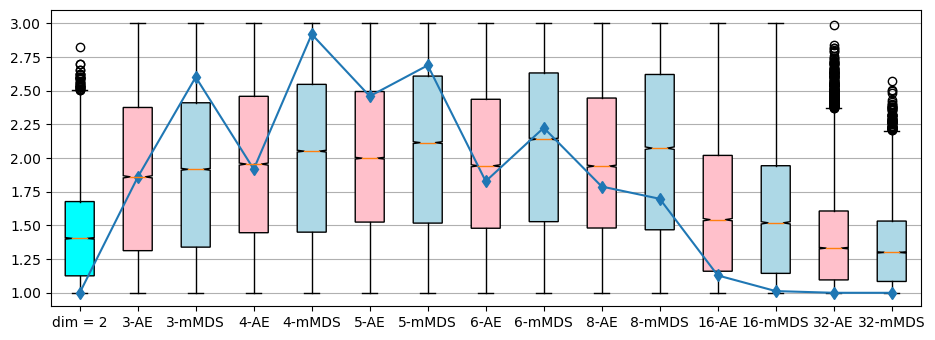

In [8]:
DF = {}

plt.rcParams["figure.figsize"] = [9.50, 3.50]
plt.rcParams["figure.autolayout"] = True
for col1_mmds, col2_auto, input_dim in zip(max_dev_mMDS, max_dev_auto, DIMENSIONS):
    col1 = torch.tensor(col2_auto).cpu().numpy()
    col2 = torch.tensor(col1_mmds).cpu().numpy()
    #col1 = np.pad(col1, (0, max(len(col1), len(col2)) - len(col1)))
    #col2 = np.pad(col2, (0, max(len(col1), len(col2)) - len(col2)) )
    if input_dim == out_dim:
        DF[f'dim = {input_dim}'] = col1
        #DF[f'{input_dim}-AE'] = col2
    else:
        DF[f'{input_dim}-AE'] = col1
        DF[f'{input_dim}-mMDS'] = col2
    
fig, ax = plt.subplots()
bplot = ax.boxplot(DF.values(), patch_artist=True, notch=True)
ax.set_xticklabels(DF.keys())

ax.yaxis.grid(True)
#ax.set_xlabel('Three separate samples')
#ax.set_ylabel('Observed values')
colors = ['pink', 'lightblue']*7
colors.insert(0, 'cyan')
for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
if refine:
    plt.plot(range(1, len(nr_refined_dumbells[1:])+1), nr_refined_dumbells[1:], marker='d')
#plt.title("Normal (Gaussian) distribution")
plt.show()


In [1]:
import matplotlib.pyplot as plt
import pandas as pd

import os
import torch
import numpy as np
from tqdm import tqdm
from autoencoder import train_autoencoder
from mMDS_NN import train_mMDS
from wspd import *
from generate_points import generate_data
from my_utils import plot_box

is_cuda = torch.cuda.is_available()
if is_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

######### SET PARAMETERS
out_dim = 2
S=4
# set what activation function to use
ac_fn = nn.Tanh()
#ac_fn = nn.ReLU()

refine = False
#########

seed = 69
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

datasets = []
datasets.append(pd.read_csv('../../data4Domagoj/jurkat_pca100.csv', header = None).drop([0], axis=1))
datasets.append(pd.read_csv('../../data4Domagoj/pbmc_pca100.csv', header = None).drop([0], axis=1))
#datasets.append(pd.read_csv('../../data4Domagoj/mouseCNSzeisel_pca100.csv', header = None).drop([0], axis=1))
#datasets.append(pd.read_csv('../../data4Domagoj/saunders_pca100.csv', header = None).drop([0], axis=1))


dumbells_auto = []
dumbells_mMDS = []
max_dev_auto = []
max_dev_mMDS = []
nr_refined_dumbells = []
for count, data in enumerate(datasets): 
    print("Computing for new dataset ")
    input_dim = data.shape[1]
    input_size = data.shape[0]
    print("input_dim = ", input_dim, " and input_size = ", input_size)
    data = torch.tensor(data.values, dtype=torch.float32)

    NormalizeData = lambda x: x # don't normalize
    n_data = NormalizeData(data).to(device)
    
    if input_dim > out_dim: # map points to out_dim, compute WSPD, and reconstruct dumbells 
        l, encoder, decoder = train_autoencoder(n_data, input_dim, out_dim = out_dim, batch_size = 512, epochs = 500, lr = 0.001, ac_fn = ac_fn, verbose = False, device = device)
        print("complete autoencoder loss: ", l)
        l, mmds_encoder = train_mMDS(n_data, input_dim, out_dim = out_dim, batch_size = 512, lr = 0.001, epochs = 500, ac_fn = ac_fn, verbose = False,  device = device)
        print("complete mMDS_NN loss: ", l)
    else:
        mmds_encoder = encoder = lambda x: x
        
     # compute WSPD for autoencoder
    dumbells_auto.append(run_wspd(encoder(n_data).detach(), verbose = True, S = S)[2])
    dist_X_wspd_diff_avg = analyse_dumbells(dumbells_auto[-1], n_data, S = S, refine = False, refine_depth = 100, verbose=True) 
    dist_X_wspd_diff_avg1 = analyse_dumbells(dumbells_auto[-1], n_data, S = S, refine = True, refine_depth = 100, verbose=True) 
    max_dev_auto.append(dist_X_wspd_diff_avg)
    max_dev_auto.append(dist_X_wspd_diff_avg1)

    print(max(dist_X_wspd_diff_avg), sum(dist_X_wspd_diff_avg)/len(dist_X_wspd_diff_avg))
    print("autoencoder: Overall increase in the number of dumbells: ", len(dist_X_wspd_diff_avg1)/len(dumbells_auto[-1]))
    nr_refined_dumbells.append(len(dist_X_wspd_diff_avg1))
    
    
    # compute WSPD for mMDS NN
    dumbells_mMDS.append(run_wspd(mmds_encoder(n_data).detach(), verbose = True, S = S)[2])
    mmds_dist_X_wspd_diff_avg = analyse_dumbells(dumbells_mMDS[-1], n_data, S = S, refine = False, refine_depth = 100, verbose=True) 
    mmds_dist_X_wspd_diff_avg1 = analyse_dumbells(dumbells_mMDS[-1], n_data, S = S, refine = True, refine_depth = 100, verbose=True)
    max_dev_mMDS.append(mmds_dist_X_wspd_diff_avg)
    max_dev_mMDS.append(mmds_dist_X_wspd_diff_avg1)
    
    print(max(mmds_dist_X_wspd_diff_avg), sum(mmds_dist_X_wspd_diff_avg)/len(mmds_dist_X_wspd_diff_avg))
    print("mmds: Overall increase in the number of dumbells: ", len(mmds_dist_X_wspd_diff_avg1)/len(dumbells_mMDS[-1]))
    nr_refined_dumbells.append(len(mmds_dist_X_wspd_diff_avg1))
        
    
 

Computing for new dataset 
input_dim =  100  and input_size =  4185


100%|██████████| 500/500 [00:14<00:00, 35.07it/s]


complete autoencoder loss:  553.0490455627441


100%|██████████| 500/500 [00:30<00:00, 16.13it/s]


complete mMDS_NN loss:  12862.684326171875
wsp: temp.tsv --> temp.tsv.wsp_out.txt
Reading file: temp.tsv, target sep: 4
nr_points = 4185 and dim = 2
done in 0.007734 secs
Sorting points ... done in 0.00154 secs
Building Tree ... done in 0.003181 secs
Finding pairs ...done in 0.186173 secs
4.000000, 63192;
Upper bound on the number of WS pairs: 7.76181e+06
wspd done in 0.20719647407531738 secs
wspd contains  63192  dumbells


63192it [00:03, 20073.50it/s]


depth = 0, deleted dumbells: 0, added dumbells: 0


100%|██████████| 63192/63192 [00:02<00:00, 22670.27it/s]
63192it [00:06, 10134.99it/s]


depth = 0, deleted dumbells: 1747, added dumbells: 3494


64939it [00:04, 14132.63it/s]


depth = 1, deleted dumbells: 438, added dumbells: 876


65377it [00:04, 15615.66it/s]


depth = 2, deleted dumbells: 214, added dumbells: 428


65591it [00:03, 16825.51it/s]


depth = 3, deleted dumbells: 136, added dumbells: 272


65727it [00:03, 16990.59it/s]


depth = 4, deleted dumbells: 110, added dumbells: 220


65837it [00:03, 17401.85it/s]


depth = 5, deleted dumbells: 81, added dumbells: 162


65918it [00:03, 17361.34it/s]


depth = 6, deleted dumbells: 62, added dumbells: 124


65980it [00:03, 17693.87it/s]


depth = 7, deleted dumbells: 50, added dumbells: 100


66030it [00:03, 17659.87it/s]


depth = 8, deleted dumbells: 44, added dumbells: 88


66074it [00:03, 18236.82it/s]


depth = 9, deleted dumbells: 38, added dumbells: 76


66112it [00:03, 18329.50it/s]


depth = 10, deleted dumbells: 29, added dumbells: 58


66141it [00:03, 18602.55it/s]


depth = 11, deleted dumbells: 26, added dumbells: 52


66167it [00:03, 18680.65it/s]


depth = 12, deleted dumbells: 23, added dumbells: 46


66190it [00:03, 18858.35it/s]


depth = 13, deleted dumbells: 16, added dumbells: 32


66206it [00:03, 17745.51it/s]


depth = 14, deleted dumbells: 15, added dumbells: 30


66221it [00:03, 17831.06it/s]


depth = 15, deleted dumbells: 15, added dumbells: 30


66236it [00:03, 18366.17it/s]


depth = 16, deleted dumbells: 12, added dumbells: 24


66248it [00:03, 16858.68it/s]


depth = 17, deleted dumbells: 10, added dumbells: 20


66258it [00:03, 17431.03it/s]


depth = 18, deleted dumbells: 11, added dumbells: 22


66269it [00:03, 18177.34it/s]


depth = 19, deleted dumbells: 10, added dumbells: 20


66279it [00:03, 17484.72it/s]


depth = 20, deleted dumbells: 8, added dumbells: 16


66287it [00:03, 17035.75it/s]


depth = 21, deleted dumbells: 6, added dumbells: 12


66293it [00:03, 17813.37it/s]


depth = 22, deleted dumbells: 6, added dumbells: 12


66299it [00:03, 17540.71it/s]


depth = 23, deleted dumbells: 4, added dumbells: 8


66303it [00:03, 17812.68it/s]


depth = 24, deleted dumbells: 6, added dumbells: 12


66309it [00:03, 17904.92it/s]


depth = 25, deleted dumbells: 4, added dumbells: 8


66313it [00:03, 17919.18it/s]


depth = 26, deleted dumbells: 5, added dumbells: 10


66318it [00:03, 17941.60it/s]


depth = 27, deleted dumbells: 5, added dumbells: 10


66323it [00:03, 17640.96it/s]


depth = 28, deleted dumbells: 4, added dumbells: 8


66327it [00:03, 17562.93it/s]


depth = 29, deleted dumbells: 5, added dumbells: 10


66332it [00:03, 18236.95it/s]


depth = 30, deleted dumbells: 5, added dumbells: 10


66337it [00:03, 18489.62it/s]


depth = 31, deleted dumbells: 5, added dumbells: 10


66342it [00:03, 18480.48it/s]


depth = 32, deleted dumbells: 5, added dumbells: 10


66347it [00:03, 18622.63it/s]


depth = 33, deleted dumbells: 4, added dumbells: 8


66351it [00:03, 18424.14it/s]


depth = 34, deleted dumbells: 4, added dumbells: 8


66355it [00:03, 18025.68it/s]


depth = 35, deleted dumbells: 4, added dumbells: 8


66359it [00:03, 18002.45it/s]


depth = 36, deleted dumbells: 3, added dumbells: 6


66362it [00:03, 18518.63it/s]


depth = 37, deleted dumbells: 2, added dumbells: 4


66364it [00:03, 18346.91it/s]


depth = 38, deleted dumbells: 2, added dumbells: 4


66366it [00:03, 18573.77it/s]


depth = 39, deleted dumbells: 2, added dumbells: 4


66368it [00:03, 18970.29it/s]


depth = 40, deleted dumbells: 2, added dumbells: 4


66370it [00:03, 18714.64it/s]


depth = 41, deleted dumbells: 2, added dumbells: 4


66372it [00:03, 18094.85it/s]


depth = 42, deleted dumbells: 2, added dumbells: 4


66374it [00:03, 17810.26it/s]


depth = 43, deleted dumbells: 2, added dumbells: 4


66376it [00:03, 18370.06it/s]


depth = 44, deleted dumbells: 2, added dumbells: 4


66378it [00:03, 18100.35it/s]


depth = 45, deleted dumbells: 2, added dumbells: 4


66380it [00:03, 18142.23it/s]


depth = 46, deleted dumbells: 1, added dumbells: 2


66381it [00:03, 17713.51it/s]


depth = 47, deleted dumbells: 1, added dumbells: 2


66382it [00:03, 17876.34it/s]


depth = 48, deleted dumbells: 1, added dumbells: 2


66383it [00:03, 18456.42it/s]


depth = 49, deleted dumbells: 1, added dumbells: 2


66384it [00:03, 18513.73it/s]


depth = 50, deleted dumbells: 1, added dumbells: 2


66385it [00:03, 18910.90it/s]


depth = 51, deleted dumbells: 1, added dumbells: 2


66386it [00:03, 18485.88it/s]


depth = 52, deleted dumbells: 1, added dumbells: 2


66387it [00:03, 19153.86it/s]


depth = 53, deleted dumbells: 0, added dumbells: 0


100%|██████████| 66387/66387 [00:03<00:00, 20891.84it/s]


tensor(3.8241) tensor(1.2426)
autoencoder: Overall increase in the number of dumbells:  1.0505601974933536
wsp: temp.tsv --> temp.tsv.wsp_out.txt
Reading file: temp.tsv, target sep: 4
nr_points = 4185 and dim = 2
done in 0.007224 secs
Sorting points ... done in 0.002776 secs
Building Tree ... done in 0.005721 secs
Finding pairs ...done in 0.317679 secs
4.000000, 98016;
Upper bound on the number of WS pairs: 7.76181e+06
wspd done in 0.341001033782959 secs
wspd contains  98016  dumbells


98016it [00:05, 19032.93it/s]


depth = 0, deleted dumbells: 0, added dumbells: 0


100%|██████████| 98016/98016 [00:04<00:00, 22823.71it/s]
98016it [00:05, 19231.07it/s]


depth = 0, deleted dumbells: 138, added dumbells: 276


98154it [00:05, 19162.97it/s]


depth = 1, deleted dumbells: 14, added dumbells: 28


98168it [00:05, 19105.09it/s]


depth = 2, deleted dumbells: 1, added dumbells: 2


98169it [00:05, 19184.82it/s]


depth = 3, deleted dumbells: 0, added dumbells: 0


100%|██████████| 98169/98169 [00:04<00:00, 22220.73it/s]


tensor(3.0001) tensor(1.2222)
mmds: Overall increase in the number of dumbells:  1.0015609696376102
Computing for new dataset 
input_dim =  100  and input_size =  68579


100%|██████████| 500/500 [03:36<00:00,  2.30it/s]


complete autoencoder loss:  2272.915214538574


100%|██████████| 500/500 [08:42<00:00,  1.04s/it]


complete mMDS_NN loss:  82497.14862060547
wsp: temp.tsv --> temp.tsv.wsp_out.txt
Reading file: temp.tsv, target sep: 4
nr_points = 68579 and dim = 2
done in 0.068419 secs
Sorting points ... done in 0.034986 secs
Building Tree ... done in 0.074527 secs
Finding pairs ...done in 7.19216 secs
4.000000, 1827134;
Upper bound on the number of WS pairs: 1.2722e+08
wspd done in 7.55901837348938 secs
wspd contains  1827134  dumbells


1827134it [01:51, 16342.90it/s]


depth = 0, deleted dumbells: 0, added dumbells: 0


100%|██████████| 1827134/1827134 [01:47<00:00, 16971.92it/s]
1827134it [02:06, 14433.48it/s]


depth = 0, deleted dumbells: 1994, added dumbells: 3988


1829128it [02:02, 14960.57it/s]


depth = 1, deleted dumbells: 505, added dumbells: 1010


1829633it [02:00, 15195.47it/s]


depth = 2, deleted dumbells: 288, added dumbells: 576


1829921it [02:00, 15175.38it/s]


depth = 3, deleted dumbells: 190, added dumbells: 380


1830111it [01:57, 15571.52it/s]


depth = 4, deleted dumbells: 141, added dumbells: 282


1830252it [01:56, 15674.20it/s]


depth = 5, deleted dumbells: 112, added dumbells: 224


1830364it [01:56, 15660.65it/s]


depth = 6, deleted dumbells: 96, added dumbells: 192


1830460it [01:57, 15581.00it/s]


depth = 7, deleted dumbells: 80, added dumbells: 160


1830540it [01:54, 16016.29it/s]


depth = 8, deleted dumbells: 71, added dumbells: 142


1830611it [01:54, 16051.33it/s]


depth = 9, deleted dumbells: 62, added dumbells: 124


1830673it [01:54, 16023.91it/s]


depth = 10, deleted dumbells: 52, added dumbells: 104


1830725it [01:54, 15961.68it/s]


depth = 11, deleted dumbells: 46, added dumbells: 92


1830771it [01:53, 16135.59it/s]


depth = 12, deleted dumbells: 39, added dumbells: 78


1830810it [01:54, 16046.07it/s]


depth = 13, deleted dumbells: 34, added dumbells: 68


1830844it [01:53, 16103.64it/s]


depth = 14, deleted dumbells: 32, added dumbells: 64


1830876it [01:56, 15710.21it/s]


depth = 15, deleted dumbells: 25, added dumbells: 50


1830901it [01:57, 15632.02it/s]


depth = 16, deleted dumbells: 21, added dumbells: 42


1830922it [01:56, 15684.38it/s]


depth = 17, deleted dumbells: 19, added dumbells: 38


1830941it [01:56, 15739.89it/s]


depth = 18, deleted dumbells: 18, added dumbells: 36


1830959it [01:53, 16195.24it/s]


depth = 19, deleted dumbells: 16, added dumbells: 32


1830975it [01:52, 16260.67it/s]


depth = 20, deleted dumbells: 13, added dumbells: 26


1830988it [01:52, 16298.21it/s]


depth = 21, deleted dumbells: 13, added dumbells: 26


1831001it [01:52, 16254.86it/s]


depth = 22, deleted dumbells: 11, added dumbells: 22


1831012it [01:51, 16391.02it/s]


depth = 23, deleted dumbells: 10, added dumbells: 20


1831022it [01:52, 16214.70it/s]


depth = 24, deleted dumbells: 9, added dumbells: 18


1831031it [01:52, 16233.59it/s]


depth = 25, deleted dumbells: 9, added dumbells: 18


1831040it [01:54, 15999.58it/s]


depth = 26, deleted dumbells: 9, added dumbells: 18


1831049it [01:53, 16125.80it/s]


depth = 27, deleted dumbells: 7, added dumbells: 14


1831056it [01:53, 16176.18it/s]


depth = 28, deleted dumbells: 5, added dumbells: 10


1831061it [01:55, 15848.29it/s]


depth = 29, deleted dumbells: 5, added dumbells: 10


1831066it [01:54, 15961.69it/s]


depth = 30, deleted dumbells: 5, added dumbells: 10


1831071it [01:53, 16201.99it/s]


depth = 31, deleted dumbells: 4, added dumbells: 8


1831075it [01:55, 15901.37it/s]


depth = 32, deleted dumbells: 4, added dumbells: 8


1831079it [01:56, 15670.92it/s]


depth = 33, deleted dumbells: 4, added dumbells: 8


1831083it [01:54, 16023.48it/s]


depth = 34, deleted dumbells: 3, added dumbells: 6


1831086it [01:55, 15801.27it/s]


depth = 35, deleted dumbells: 3, added dumbells: 6


1831089it [01:52, 16290.34it/s]


depth = 36, deleted dumbells: 3, added dumbells: 6


1831092it [01:52, 16261.70it/s]


depth = 37, deleted dumbells: 3, added dumbells: 6


1831095it [01:53, 16197.39it/s]


depth = 38, deleted dumbells: 3, added dumbells: 6


1831098it [01:53, 16141.55it/s]


depth = 39, deleted dumbells: 3, added dumbells: 6


1831101it [01:54, 16002.54it/s]


depth = 40, deleted dumbells: 3, added dumbells: 6


1831104it [01:54, 15998.94it/s]


depth = 41, deleted dumbells: 3, added dumbells: 6


1831107it [01:53, 16074.76it/s]


depth = 42, deleted dumbells: 3, added dumbells: 6


1831110it [01:54, 15989.52it/s]


depth = 43, deleted dumbells: 3, added dumbells: 6


1831113it [01:53, 16066.83it/s]


depth = 44, deleted dumbells: 3, added dumbells: 6


1831116it [02:36, 11687.97it/s]


depth = 45, deleted dumbells: 3, added dumbells: 6


1831119it [02:44, 11158.11it/s]


depth = 46, deleted dumbells: 3, added dumbells: 6


1831122it [01:54, 16023.43it/s]


depth = 47, deleted dumbells: 2, added dumbells: 4


1831124it [01:54, 16053.44it/s]


depth = 48, deleted dumbells: 2, added dumbells: 4


1831126it [02:10, 14053.65it/s]


depth = 49, deleted dumbells: 2, added dumbells: 4


1831128it [02:18, 13254.94it/s]


depth = 50, deleted dumbells: 2, added dumbells: 4


1831130it [02:47, 10940.11it/s]


depth = 51, deleted dumbells: 2, added dumbells: 4


1831132it [02:46, 11001.79it/s]


depth = 52, deleted dumbells: 2, added dumbells: 4


1831134it [02:01, 15038.69it/s]


depth = 53, deleted dumbells: 2, added dumbells: 4


1831136it [01:54, 15923.65it/s]


depth = 54, deleted dumbells: 1, added dumbells: 2


1831137it [01:55, 15824.87it/s]


depth = 55, deleted dumbells: 1, added dumbells: 2


1831138it [01:59, 15362.51it/s]


depth = 56, deleted dumbells: 1, added dumbells: 2


1831139it [01:52, 16270.21it/s]


depth = 57, deleted dumbells: 1, added dumbells: 2


1831140it [01:51, 16418.73it/s]


depth = 58, deleted dumbells: 1, added dumbells: 2


1831141it [01:51, 16457.01it/s]


depth = 59, deleted dumbells: 1, added dumbells: 2


1831142it [01:51, 16482.39it/s]


depth = 60, deleted dumbells: 1, added dumbells: 2


1831143it [01:52, 16213.92it/s]


depth = 61, deleted dumbells: 1, added dumbells: 2


1831144it [01:52, 16340.26it/s]


depth = 62, deleted dumbells: 0, added dumbells: 0


100%|██████████| 1831144/1831144 [01:41<00:00, 17989.51it/s]


tensor(3.7798) tensor(1.2128)
autoencoder: Overall increase in the number of dumbells:  1.0021946939852249
wsp: temp.tsv --> temp.tsv.wsp_out.txt
Reading file: temp.tsv, target sep: 4
nr_points = 68579 and dim = 2
done in 0.061236 secs
Sorting points ... done in 0.033987 secs
Building Tree ... done in 0.075974 secs
Finding pairs ...done in 7.29762 secs
4.000000, 1843976;
Upper bound on the number of WS pairs: 1.2722e+08
wspd done in 7.640440464019775 secs
wspd contains  1843976  dumbells


1843976it [01:50, 16697.52it/s]


depth = 0, deleted dumbells: 0, added dumbells: 0


100%|██████████| 1843976/1843976 [01:38<00:00, 18789.68it/s]
1843976it [02:11, 14037.26it/s]


depth = 0, deleted dumbells: 12440, added dumbells: 24880


1856416it [02:09, 14375.58it/s]


depth = 1, deleted dumbells: 3099, added dumbells: 6198


1859515it [02:05, 14869.29it/s]


depth = 2, deleted dumbells: 188, added dumbells: 376


1859703it [02:04, 14956.76it/s]


depth = 3, deleted dumbells: 43, added dumbells: 86


1859746it [02:05, 14865.65it/s]


depth = 4, deleted dumbells: 12, added dumbells: 24


1859758it [02:06, 14756.84it/s]


depth = 5, deleted dumbells: 5, added dumbells: 10


1859763it [02:05, 14821.77it/s]


depth = 6, deleted dumbells: 2, added dumbells: 4


1859765it [02:03, 15006.08it/s]


depth = 7, deleted dumbells: 1, added dumbells: 2


1859766it [02:00, 15488.30it/s]


depth = 8, deleted dumbells: 0, added dumbells: 0


100%|██████████| 1859766/1859766 [01:40<00:00, 18523.70it/s]


tensor(2.9381) tensor(1.2479)
mmds: Overall increase in the number of dumbells:  1.0085630181737724


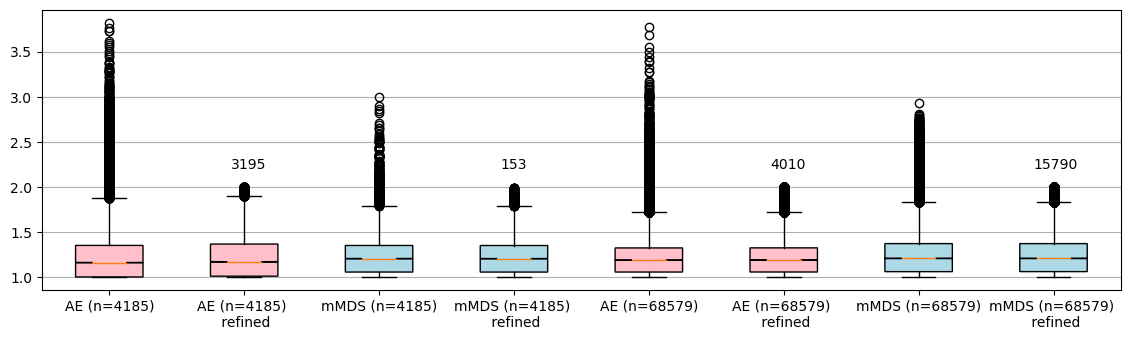

In [6]:
DF = {}

plt.rcParams["figure.figsize"] = [11.50, 3.50]
plt.rcParams["figure.autolayout"] = True
#for col1_mmds, col2_auto, input_dim in zip(max_dev_mMDS, max_dev_auto, [100, 101, 102, 103]):
DF[f'AE (n={4185})'] = torch.tensor(max_dev_auto[0]).cpu().numpy()
DF[f'AE (n={4185}) \n refined'] = torch.tensor(max_dev_auto[1]).cpu().numpy()
DF[f'mMDS (n={4185})'] = torch.tensor(max_dev_mMDS[0]).cpu().numpy()
DF[f'mMDS (n={4185}) \n refined'] = torch.tensor(max_dev_mMDS[1]).cpu().numpy()
DF[f'AE (n={68579})'] = torch.tensor(max_dev_auto[2]).cpu().numpy()
DF[f'AE (n={68579}) \n refined'] = torch.tensor(max_dev_auto[3]).cpu().numpy()
DF[f'mMDS (n={68579})'] = torch.tensor(max_dev_mMDS[2]).cpu().numpy()
DF[f'mMDS (n={68579}) \n refined'] = torch.tensor(max_dev_mMDS[3]).cpu().numpy()

 
 
    
fig, ax = plt.subplots()
bplot = ax.boxplot(DF.values(), patch_artist=True, notch=True)
ax.set_xticklabels(DF.keys())

ax.yaxis.grid(True)
#ax.set_xlabel('Three separate samples')
#ax.set_ylabel('Observed values')
colors = ['pink', 'pink', 'lightblue', 'lightblue']*2
#colors.insert(0, 'cyan')
for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
#if refine:
#plt.plot(range(1, len(nr_refined_dumbells[1:])+1), nr_refined_dumbells[1:], marker='d')
#plt.title("Normal (Gaussian) distribution")
plt.text(1.9,2.2,f'{nr_refined_dumbells[0]-len(dumbells_auto[0])}')
plt.text(3.9,2.2,f'{nr_refined_dumbells[1]-len(dumbells_mMDS[0])}')
plt.text(5.9,2.2,f'{nr_refined_dumbells[2]-len(dumbells_auto[1])}')
plt.text(7.85,2.2,f'{nr_refined_dumbells[3]-len(dumbells_mMDS[1])}')
#plt.plot([3, 3, 3, 3, 3, 3, 3, 3], [1, 2, 3, 4, 5, 6, 7, 8])
plt.show()